# Basic feed-foreward ANN Model

**We already know that the airline passengers data shows a linear trend as well as seasonality, so it is an excellent dataset to demonstrate the power of a regression neural network, compared to the more standardized models.**

**Using TensorFlow, build an ANN model that forecasts the univariate time series, i.e. specified number of timesteps in the future, after the end of the training set. Since Keras API in TensorFlow behaves similar to SciKit-Learn, you need to create a 'supervised' dataset, i.e. input *X* and target *Y* variables. This is a regression model so you can use three types of forecasting - one-step, incremental multi-step, which incrementally returns multiple timesteps into the future, and multi-output multi-step, which outputs multiple timesteps into the future in one go.**

**NOTE: You must ensure stationarity in data to train the model, by log-transformation and differencing. This means you need to undo the differencing before forecasting in order to return predictions on the same scale as original data. There are some neural networks that are powerful enough that differencing is not necessary, but that can only be known by testing.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# To return consistent results - in the real world, turn this off
np.random.seed(123)

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

# To return consistent results
tf.random.set_seed(123)

In [3]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
# Index frequency is start of the month

df = pd.read_csv('data/airline_passengers.csv', index_col='Month', parse_dates=True)

In [5]:
df['LogPassengers'] = np.log(df['Passengers'])

In [6]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

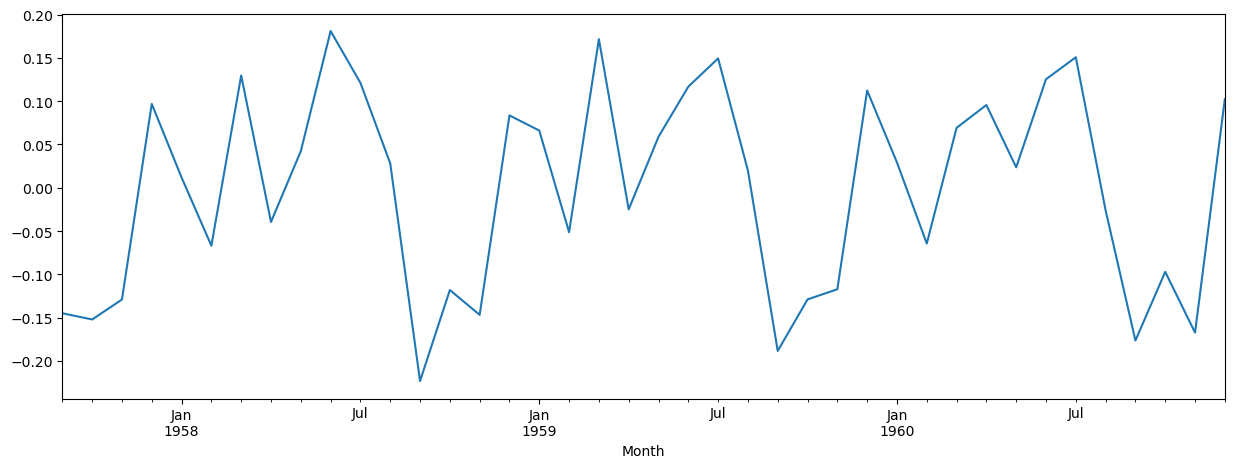

In [7]:
# Plot most recent months - looks stationary...

df['DiffLogPassengers'][-40:].plot(figsize=(15, 5));

In [8]:
# Note null value due to differencing

df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [9]:
# Create training and test sets

N_test = 12

train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [10]:
# Boolean series to index df rows

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

## Make 'supervised' dataset

**Create input *X* and target *Y* variables using AutoRegressive method with *T* past values to predict the next value. From there, you can split *X* and *Y* into training and test sets used for supervised machine-learning.**

**The T number of past lags defines how many columns in the *X* variable for input to predicting the next value. It is also the input shape specification for the ANN model. The target variable contains a single value for each timestep, which is the predicted next value after AutoRegression.**

**NOTE: Remember that the time series has been differenced to ensure stationarity. The ANN is trained on the differenced data, but you will need to undo the differencing before generating predictions on the same scale as the original data.**

In [11]:
series = df['DiffLogPassengers'].dropna().to_numpy()

# 10 past lags
T = 10
X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

# Convert to NumPy arrays
X = np.array(X).reshape(-1, T)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [12]:
# Split X and Y into X_train, y_train, X_test, y_test

X_train, y_train = X[:-N_test], Y[:-N_test]

X_test, y_test = X[-N_test:], Y[-N_test:]

## Build basic ANN

**The basic ANN is a feed-forward network that works for tabular data and univariate time series.** 

**To create the model:**

* **The inner layer, or `Input`, specifies the dimension of your input, *T* x *N*, where *T* is the number of features. In a time series, each feature is the current or past timestep values.**

* **The hidden layer(s), or `Dense` layer, specifies the number of hidden nodes and activation function to be used. You can chain in more dense layers to make a deeper neural network in order to improve model performance, but this is a matter of trial-and-error. For regression tasks, the standard starting point is 32 nodes and ReLU activation function.**

* **The outer layer, or the final `Dense` layer, specifies the number of outputs, *K*. For example, for one-step forecast `K=1`, and for ten multi-output forecast `K=10` etc.**

**The model is instantiated by passing in the input and chain of subsequent layers.**

**NOTE: Remember to flatten predictions to 1D NumPy array before adding to them original data and plotting.**

In [13]:
i = Input(shape=(T,))

x = Dense(32, activation='relu')(i)

x = Dense(1)(x)

model = Model(i, x)

In [14]:
# Tell model what to optimize - can add additional metrics, like MAE

model.compile(loss='mse', optimizer='adam')

In [15]:
# Train the model - epochs is number of loops over the training data

r = model.fit(X_train, 
              y_train, 
              epochs=150, 
              validation_data=(X_test, y_test))

Epoch 1/150
4/4 [==============================] - 1s 52ms/step - loss: 0.0221 - val_loss: 0.0225
Epoch 2/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0191 - val_loss: 0.0198
Epoch 3/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0178
Epoch 4/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0152 - val_loss: 0.0163
Epoch 5/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0143 - val_loss: 0.0152
Epoch 6/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0134 - val_loss: 0.0143
Epoch 7/150
4/4 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0136
Epoch 8/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0119 - val_loss: 0.0130
Epoch 9/150
4/4 [==============================] - 0s 13ms/step - loss: 0.0113 - val_loss: 0.0124
Epoch 10/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0108 - val_loss: 0.0119
Epoch 11/150
4/4 [==

Epoch 84/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 85/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 86/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 87/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 88/150
4/4 [==============================] - 0s 13ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 89/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 90/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 91/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 92/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 93/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0011 - val_loss: 0.0035
Epoch 94/150

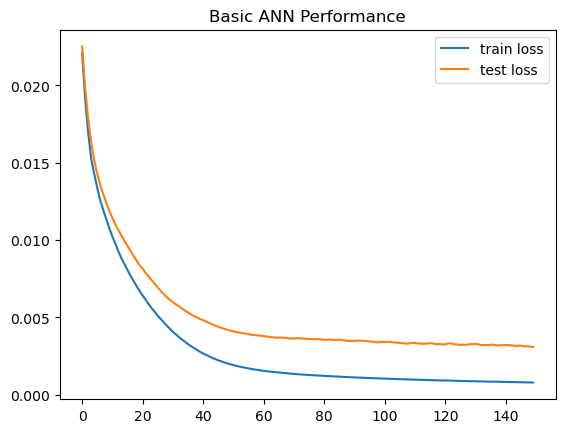

In [16]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Basic ANN Performance")
plt.legend();

**As you can see, both training and test losses decrease steadily (training errors lower as expected) with the test loss maintaining level after approx. 100 epochs. You could increase number of epochs to fully assess whether this result is reasonable.**

### One-step forecasting

**Since the model uses *T* past lags to predict for the next value, the first eleven values in the training set are unpredictable, because they need ten previous values. You can set these rows to False in the Boolean series.**

In [17]:
# For Boolean indexing, first T + 1 values are not predictable

train_idx[:T+1] = False

In [18]:
# Predict with model (remember that this is differenced data)

P_train = model.predict(X_train).flatten()

P_test = model.predict(X_test).flatten()

1/1 [==============================] - 0s 18ms/step


In [19]:
# Store differenced predictions in original data

df.loc[train_idx, 'Diff ANN Train Prediction'] = P_train
df.loc[test_idx, 'Diff ANN Test Prediction'] = P_test

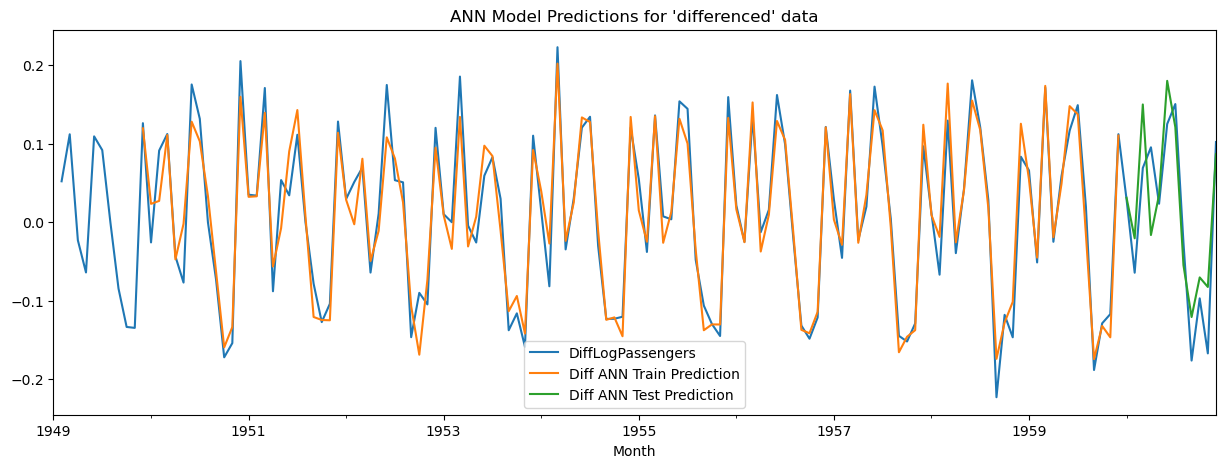

In [25]:
# Plot differenced results against diffed data

cols = ['DiffLogPassengers', 'Diff ANN Train Prediction', 'Diff ANN Test Prediction']

df[cols].plot(figsize=(15, 5))
plt.title("ANN Model Predictions for 'differenced' data");

**This looks pretty good, but remember this is just the one-step prediction for differenced data.**

### Compute 'un-differenced' predictions

**Shift the log-transformed data up by one and store in a separate series. Use that series to index the training and test sets at the shifted index positions to add the predictions at the correct date.**

In [21]:
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)

prev = df['ShiftLogPassengers']

In [22]:
# Obtain last-known training value

last_train = train.iloc[-1]['LogPassengers']

**Add the predictions for the differenced data at the shifted index locations so that the date values match up.**

In [23]:
df.loc[train_idx, 'onestep_train'] = prev[train_idx] + P_train

df.loc[test_idx, 'onestep_test'] = prev[test_idx] + P_test

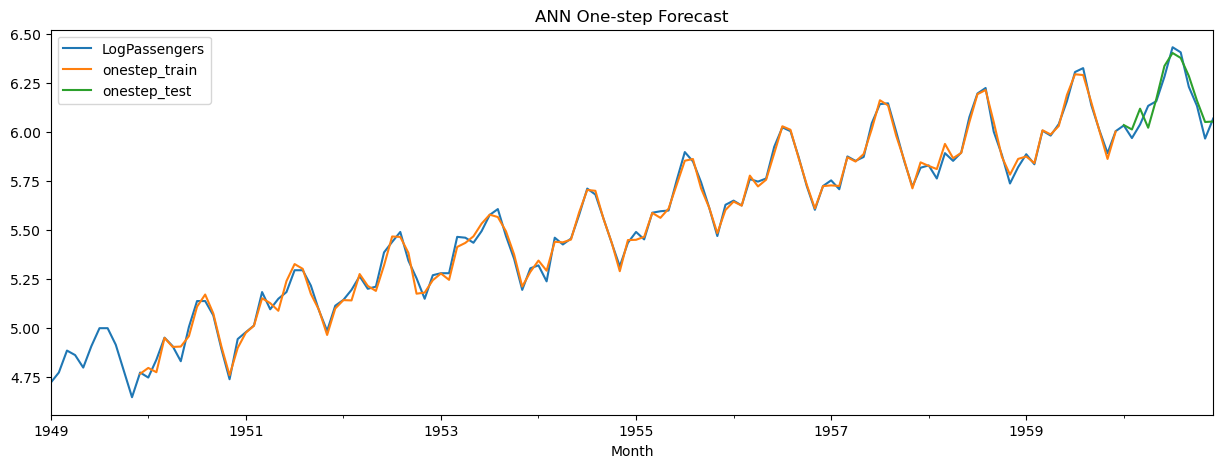

In [26]:
df[['LogPassengers', 'onestep_train', 'onestep_test']].plot(figsize=(15, 5))
plt.title("ANN One-step Forecast");

**This looks pretty accurate. However, this is just one type of forecasting used for the entire dataset. The multi-step forecasting assesses the model performance on the test set only.**

### Incremental Multi-step forecast

**The code below also includes 'un-differencing' the multi-step predictions, when storing the predictions in the original data. The last training set value is added to the cumulatively-summed values from the multi-step predictions.**

In [27]:
multistep_predictions = []

# Obtain first test input
last_x = X_test[0]

while len(multistep_predictions) < N_test:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 21ms/step


In [28]:
# Save multi-step forecast to dataframe

df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

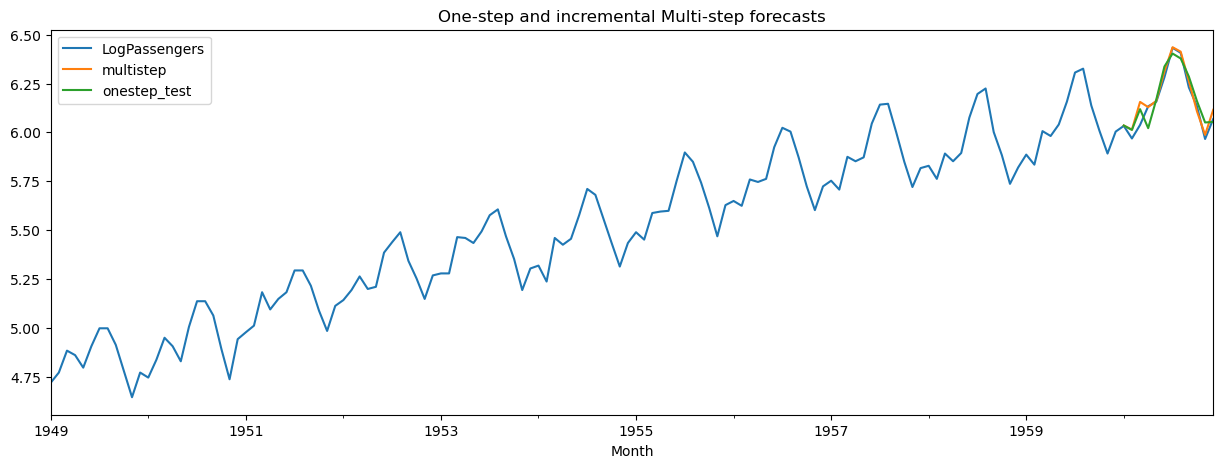

In [30]:
df[['LogPassengers', 'multistep', 'onestep_test']].plot(figsize=(15, 5))
plt.title("One-step and incremental Multi-step forecasts");

**From appearance, the multi-step slightly outperforms the one-step predictions, showing it has learnt the pattern of the data better.**

### Multi-output Multi-step forecast

**You need to re-create the 'supervised' dataset, so that the target variable *Y* contains the multiple predictions into the future for each sample, i.e. each timestep.**

In [31]:
Tx = T
Ty = N_test
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

# Convert to NumPy array easier to index
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [32]:
# Use different naming for training and test sets

Xtrain, Ytrain = X[:-1], Y[:-1]

Xtest, Ytest = X[-1:], Y[-1:]

### Rebuild basic ANN 

**You need to re-build the ANN because the structure specifications have changed, as well as new training and test sets from the new supervised dataset.**

**The inner layer dimensions are the same as before, i.e. *T*. But the outer layer dimension has changed, because the output is not one timestep into the future, but ten timesteps into the future.**

In [33]:
i = Input(shape=(Tx,))

x = Dense(32, activation='relu')(i)

x = Dense(Ty)(x)

model = Model(i, x)

In [34]:
model.compile(loss='mse', optimizer='adam')

In [35]:
r = model.fit(Xtrain, 
              Ytrain, 
              epochs=150, 
              validation_data=(Xtest, Ytest))

Epoch 1/150
4/4 [==============================] - 0s 39ms/step - loss: 0.0155 - val_loss: 0.0197
Epoch 2/150
4/4 [==============================] - 0s 14ms/step - loss: 0.0141 - val_loss: 0.0180
Epoch 3/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0130 - val_loss: 0.0166
Epoch 4/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0121 - val_loss: 0.0154
Epoch 5/150
4/4 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 6/150
4/4 [==============================] - 0s 12ms/step - loss: 0.0107 - val_loss: 0.0135
Epoch 7/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0102 - val_loss: 0.0128
Epoch 8/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0098 - val_loss: 0.0120
Epoch 9/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0094 - val_loss: 0.0114
Epoch 10/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0090 - val_loss: 0.0108
Epoch 11/150
4/4 [==

4/4 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 85/150
4/4 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 86/150
4/4 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 87/150
4/4 [==============================] - 0s 9ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 88/150
4/4 [==============================] - 0s 7ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 89/150
4/4 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 90/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 91/150
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 92/150
4/4 [==============================] - 0s 5ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 93/150
4/4 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 94/150
4/4 [============

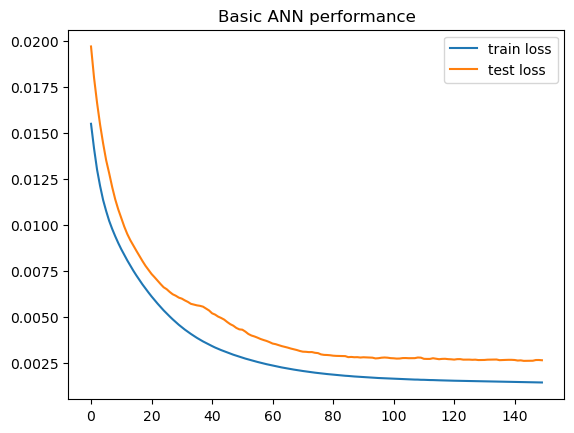

In [36]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("Basic ANN performance")
plt.legend();

**Minimum error is slightly lower than the model used for one-step forecasting.**

In [37]:
# Predict with model - no need to flatten

Ptrain = model.predict(Xtrain)

Ptest = model.predict(Xtest)

1/1 [==============================] - 0s 18ms/step


In [38]:
# N_steps into the future for each sample

Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [39]:
# Use 1st prediction as the twelth forecast, i.e. one-step (closest to current value)

Ptrain = Ptrain[:, 0]

Ptest = Ptest[0]

In [40]:
# Save multi-output forecast to dataframe as 'un-differenced'

df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

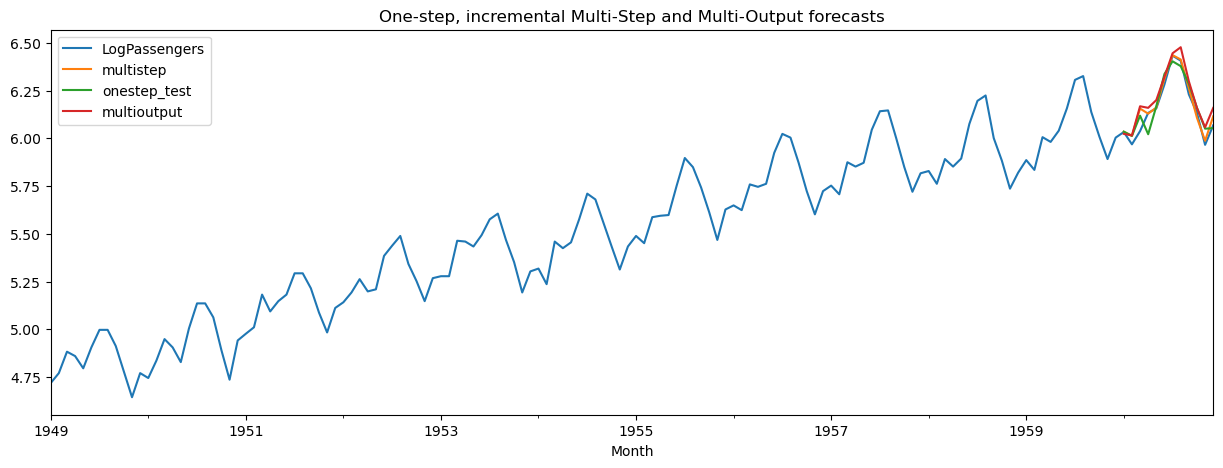

In [41]:
# Plot all forecasts

cols = ['LogPassengers', 'multistep', 'onestep_test', 'multioutput']

df[cols].plot(figsize=(15, 5))
plt.title("One-step, incremental Multi-Step and Multi-Output forecasts");

**The multi-output tends to over-estimate the true value. The incremental multi-step appears to follow the true data best.**

In [42]:
# Compute MAPE

test_log_pass = df.iloc[-N_test:]['LogPassengers']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.004656763350543899
multi-output MAPE: 0.008941352921008559


**As seen in the plots, the incremental multi-step predictions follow the true data most closely, with model accuracy approx. 50% better than multi-output method.**

**EXERCISE:**

* **Do you think differencing is unnecessary? Try without differencing**
* **Do you think log-transformation is unnecessary? Try without**
* **Do you think including more past lags would be useful?**
* **Have you considered walk-forward validation to optimize hyperparameters?**